In [2]:
!wget http://mlsm.man.dtu.dk/mbml/pystan_utils.py

--2021-05-27 07:45:34--  http://mlsm.man.dtu.dk/mbml/pystan_utils.py
Resolving mlsm.man.dtu.dk (mlsm.man.dtu.dk)... 192.38.87.226
Connecting to mlsm.man.dtu.dk (mlsm.man.dtu.dk)|192.38.87.226|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2661 (2.6K) [text/x-python]
Saving to: ‘pystan_utils.py’

pystan_utils.py     100%[===================>]   2.60K  --.-KB/s    in 0s      

2021-05-27 07:45:35 (331 MB/s) - ‘pystan_utils.py’ saved [2661/2661]



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pystan
import pystan_utils

from sklearn.model_selection import train_test_split
from sklearn import linear_model

import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Background

The chosen dataset consists of infromation about red and white variants of the Portuguese "Vinho Verde" wine. Below described are the different features of the dataset:

1. **Fixed Acidity** - the predominant acidity in wines
2. **Volatile Acidity** - the amount of acetic acid in wine, which at a too high level can lead to an unpleasant, vinegar taste
3. **Citric Acid** - in small quantities, it can add ‘freshness’ and flavor to wines
4. **Residual Sugar** - the amount of sugar remaining after fermentation stops, it’s rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
5. **Chlorides** - the amount of salt in the wine
6. **Free Sulfur Dioxide** - prevents microbial growth and the oxidation of wine
7. **Total Sulfur Dioxide** - large concentrations become evident in the nose and taste of wine
8. **Density** - the density of wine is close to that of water depending on the amount of alcohol and sugar
9. **pH** - describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
10. **Sulphates** - a wine additive which can contribute to sulfur dioxide gas levels, wich acts as an antimicrobial and antioxidant
11. **Alcohol** - alchool percentage in the wine
12. **Quality** - score between 0 and 10; based on sensory data

This dataset is already very clean, with no missing data, so the it is ready to use. 

# Research Questions

- Can we determine the **quality of wine** without tasting it, but only using its physico-chemical properties?
- Can we determine the **color of wine** without looking at it, but only using its physico-chemical properties?

# Exploratory Analysis

In [2]:
white = pd.read_csv('winequality-white.csv', sep=';')
red = pd.read_csv('winequality-red.csv', sep=';')

# Add categorical variables
white['color'] = 'white'
red['color'] = 'red'

# Merge both dataframes
data = pd.concat([white, red])

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


As presented in the table above, the variables are spread widely. Indeed, the values of total sulfur dioxide are much larger than those of the chlorides. As a consequence, it will be important to normalize the data in order to avoid a situation where the large values of total sulfur dioxide are dominant over the rest of the features. 

In [4]:
print('The dataset contains', data.shape[0], 'observations (wines) and', data.shape[1], 'features.')

The dataset contains 6497 observations (wines) and 13 features.


Some summary statistics:

In [5]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


It can be noticed that the residual sugar level has a mean of 5.4 g/l, but there is one very sweet wine with 65.8 g/l compared to the majority (75%) of the wines characterized by a residual sugar at the level lower than 8.1 g/l. Moreover, most of the wine samples (75%) have 41 ppm of free sulfur dioxide, but there is an outlier with 289 ppm (7 times more). Additionally, the pH ranges from 2.7 to 4 with a mean of 3.2, so there are no basic wine samples because the pH levels are low. As for the alcohol, the lightest wine has 8% and the strongest 14.9%. Finally, the minimum quality score is 3 and maximum is 9 out of 10. 

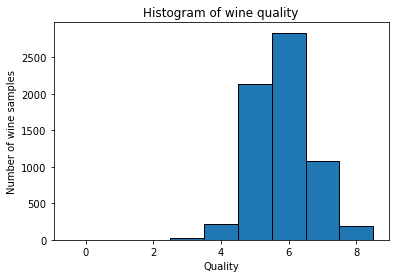

In [6]:
plt.hist(data['quality'], edgecolor='black', bins = np.arange(10)-.5)
plt.title('Histogram of wine quality')
plt.xlabel('Quality')
plt.ylabel('Number of wine samples')
plt.show()

<a name="Quality-distribution"></a>
It can be noticed that there are no very poor quality wines (<3), nor excellent samples (10), but most of the wines have an intermediate quality score (between 5 and 7). These results are not surprising since it is fairly easy to make an acceptable quality wine, but difficult to make an excellent one.  

### How are the values of chemical levels distributed?

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


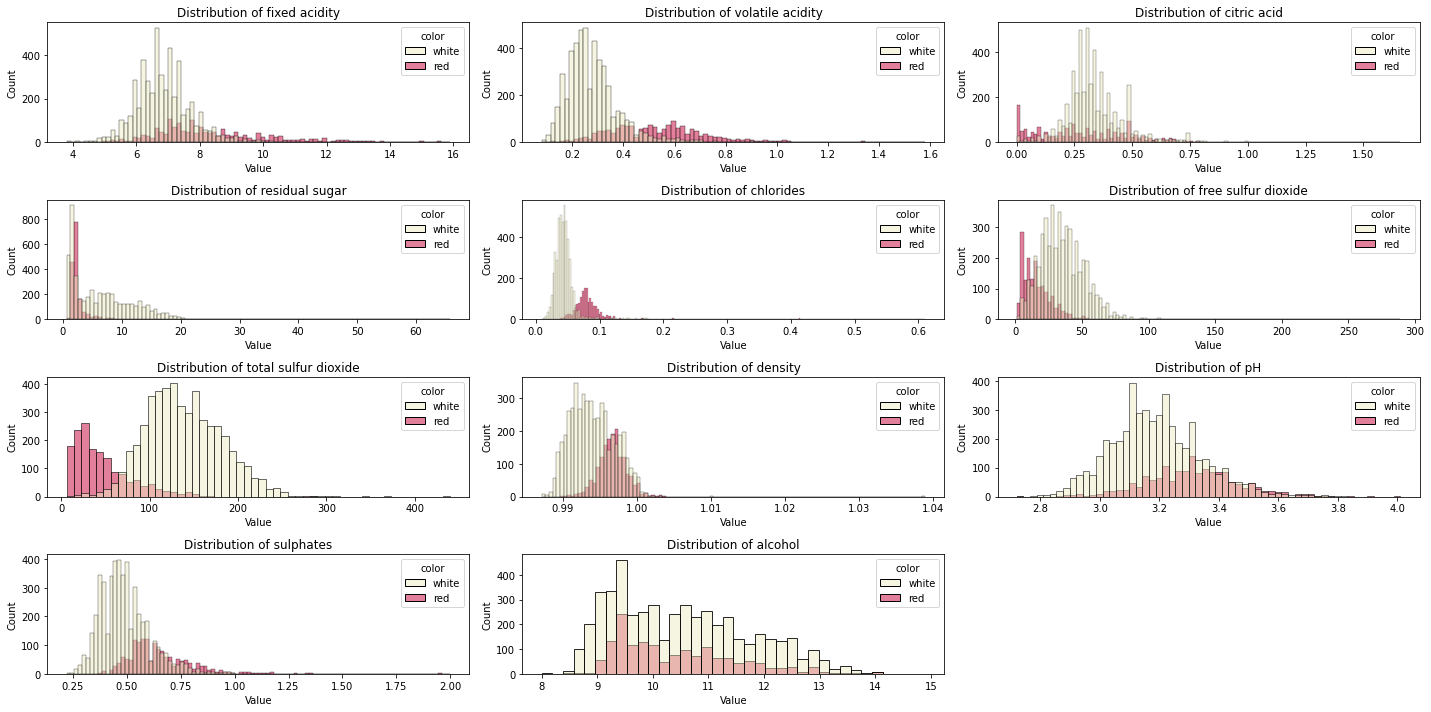

In [7]:
num_features = data.select_dtypes(exclude="object").columns[:-1]
pallete = ["#EEEDC4", "#C70039"]
plt.figure(figsize=(20, 10))
for i in range(len(num_features)):
  plt.subplot(4, 3, i+1)
  sns.histplot(data = data, x = num_features[i], hue = 'color', palette=pallete)
  plt.title("Distribution of {}".format(num_features[i]), fontsize = 12)
  plt.ylabel("Count"); plt.xlabel("Value")
plt.tight_layout()

It is clear that the values of wine properties are differently distributed. We can observe some **bimodal distributions** like total sulfur dioxide or chlorides but most of them are strongly **positively skewed**, which means that mean will usually be higher than the median.

<a name="ColorPlot"></a>
### Does the level of a given chemical property vary between wines of a different color?  
Below is a plot indicating the relative difference in the **median** level of each property between the colors. If a bar is red, it means that a red wine has a higher level of a given property and vice versa.

In [8]:
medians_white = white.describe().iloc[5, :-1]
medians_red = red.describe().iloc[5, :-1]
relative_difference = medians_red.copy()
for i in range(len(medians_white)):
  relative_difference.iloc[i] = (medians_white[i] - medians_red[i])/max(medians_white[i], medians_red[i])
relative_difference

fixed acidity          -0.139241
volatile acidity       -0.500000
citric acid             0.187500
residual sugar          0.576923
chlorides              -0.455696
free sulfur dioxide     0.588235
total sulfur dioxide    0.716418
density                -0.003020
pH                     -0.039275
sulphates              -0.241935
alcohol                 0.019231
Name: 50%, dtype: float64

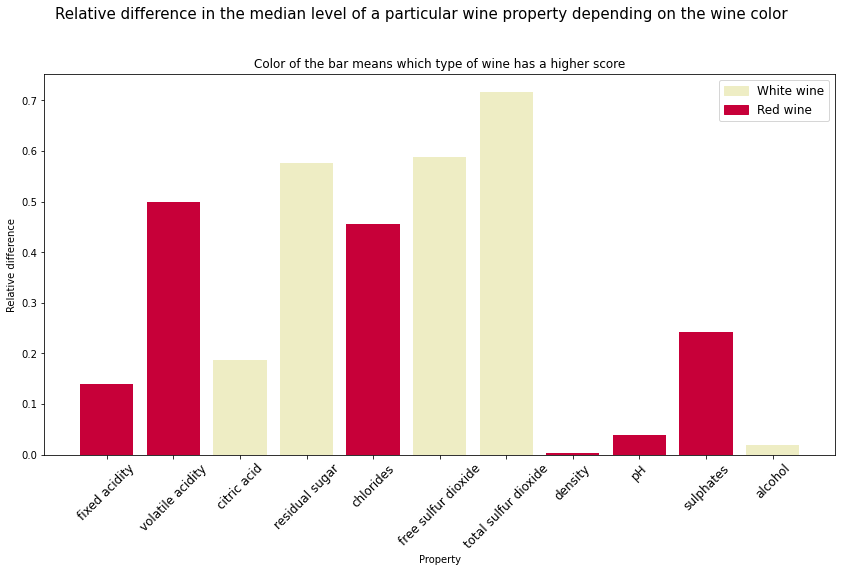

In [9]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
col = []
for val in relative_difference:
    if val < 0:
        col.append('#C70039')
    elif val >= 0:
        col.append('#EEEDC4')

legend_elements = [Patch(color='#EEEDC4', label='White wine'),
                   Patch(color='#C70039', label='Red wine')]

plt.figure(figsize = (12, 8))
plt.bar(relative_difference.index, abs(relative_difference.values), color = col)
plt.xticks(rotation = 45, size = 12)
plt.suptitle("Relative difference in the median level of a particular wine property depending on the wine color", fontsize = 15, y = 1)
plt.title("Color of the bar means which type of wine has a higher score", fontsize = 12)
plt.xlabel("Property"); plt.ylabel("Relative difference")
plt.tight_layout(pad = 1.8)
plt.legend(handles = legend_elements, fontsize = 12);

It can be observed that **white wines are characterized by a significantly higher level of residual sugar**, which is a sugar left in the wine after the fermentation process. [Given that white wines are usually being fermented for a less period of time](https://wineturtle.com/white-red-more-sugar/), this result makes sense. However, it could also be possible that there are more sweet white wines in the dataset.  
Next, from the plot it is clear that **white wines contain more dioxide**. It is reasonable as [they have less of other antioxidants than do red wines](https://www.piwine.com/use-and-measurement-of-sulfur-dioxide-in-wine.html).  
It can be concluded that **red wines contain more salt** (chlorides) than white ones.  
We can also see that **alcohol, density or pH** do not vary significantly between the colors.

### How do the levels of those chemical properties correlate with a quality?

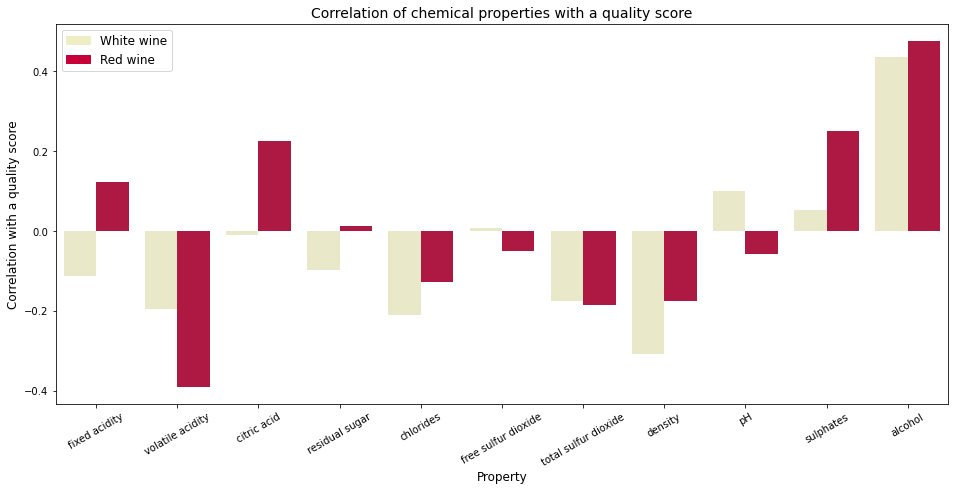

In [14]:
correlation_white = pd.DataFrame({'quality': white.corr()['quality'][:-1], 'color': ['white' for x in range(11)] })
correlation_red = pd.DataFrame({'quality': red.corr()['quality'][:-1], 'color': ['red' for x in range(11)] })
df = pd.concat([correlation_white, correlation_red])
df = df.reset_index().rename(columns = {'index': 'property'})

fig_dims = (16, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = df, x = 'property', y = 'quality', hue = 'color', ax = ax, palette=sns.color_palette(['#EEEDC4', '#C70039']))
plt.title("Correlation of chemical properties with a quality score", fontsize = 14)
plt.xlabel("Property", fontsize = 12); plt.xticks(rotation = 30, fontsize = 10)
plt.ylabel("Correlation with a quality score", fontsize = 12)
plt.legend(handles = legend_elements, fontsize = 12);

What is interesting is that ***alcohol* has the strongest positive correlation with the quality** of a wine, regardless of its color. We can also see that *volatile acidicity, chlorides, total sulful dioxide and density* are rather undesirable properties of wine. Another thing worth noting is that *citric acid* and *sulphates* may be desired chemicals in **<font color='darkred'>red</font>** wines.  
However, it must be noted, that majority of those properties have a weak correlation with the quality score.

# Linear Regression 

In this part, we will try to answer the reaseach question 1, by considering it as a linear regression problem. We wish to model the quality score of red and white wine as a function of all the features (fixed acidity, volatile, acidity, citric acid
residual sugar
chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol).  
We will assume a linear relationship. We suppose that the color has no influence.

The graphical model can be found below. The '...' mean that we have omitted mentioning some of the features in order to avoid cluttering the representation.

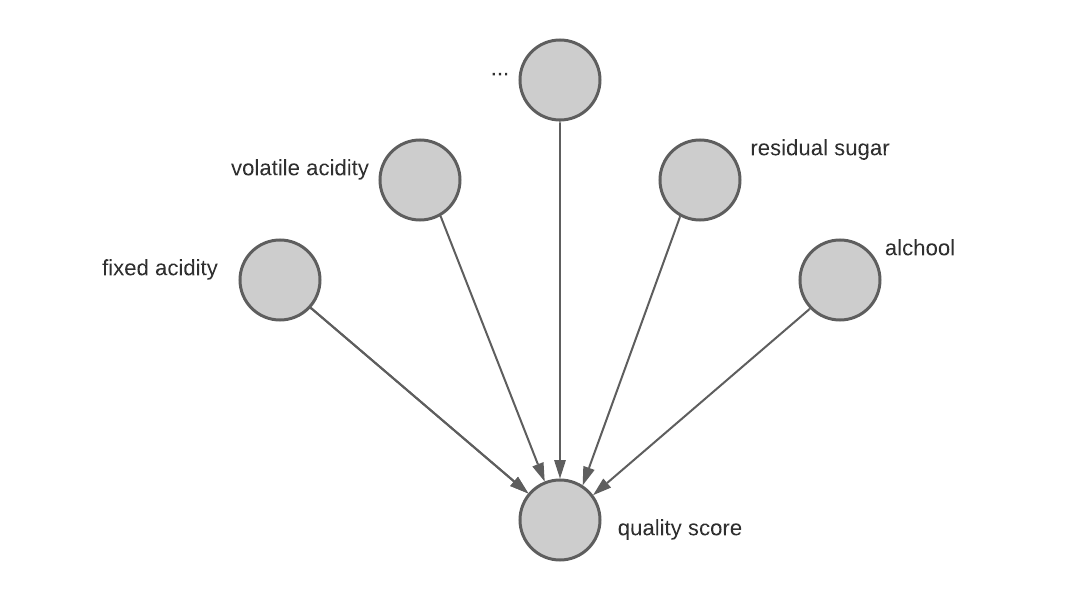

## Generative process

We have a dataset consisting of N observations of the targets $y_{n}$ which depend on their corresponding explanatory variables or features $\textbf{x}_{n} $. We will implement Bayesian linear regression using the following generative process: 
1. Draw $\alpha \sim \mathcal{N}(0, \lambda_{1})$
2. Draw $\boldsymbol\beta \sim \mathcal{N}(\boldsymbol 0, \lambda_{2} \textbf{I})$
3. Draw $\sigma \sim Cauchy(0, \lambda_{3})$
4. For each feature vector $\textbf{x}_{n}$:

    a) Draw target $y_n \sim \mathcal{N}(\alpha + \boldsymbol\beta^T \textbf{x}_n , \sigma^2)$


Where $\alpha$ is the intercept, $\sigma$ is the error scale, and $\boldsymbol\beta$ is a vector with the coefficients of the linear model.

## PGM

The PGM of this model, containing priors is the follwoing:

<img src="https://drive.google.com/uc?id=1rBx8-NELvPgSoYL361IrHjT2Gfqnu1XD" width = 400>






Now it's time to prepare the data: features and target variable.

In [15]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


In [16]:
# Input features
X = data.drop(columns=['color', 'quality']).values

# Standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [17]:
# Prepare vector of target quality
y = data["quality"].values

# Standardize outputs
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

Now that the standardized data is ready, we can split it into a train and test set.

In [18]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
# Randomization of the features and targets in the train and test sets
perm = np.random.permutation(len(y))
# Indices of permuted data points
ix_train = perm[:split_point]
ix_test = perm[split_point:]
# Features train set
X_train = X[ix_train,:]
# Features test set
X_test = X[ix_test,:]
# Target train set
y_train = y[ix_train]
# Target test set
y_test = y[ix_test]

print("Number of examples in the train data : %d" % len(y_train))
print("Number of examples in the test data: %d" % len(y_test))

Number of examples in the train data : 4288
Number of examples in the test data: 2209


We compute some statistics based on the true and predicted values in order to be able to compare the different models.

In [19]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

## Baseline

The baseline will be the linear regression from the sklearn package. We will use this for comparison with our own model.

In [20]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test) 

# Convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.523
MAE: 0.570
RMSE: 0.741
R2: 0.272


## STAN model

It's time to define the model in STAN.

In [21]:
model_definition = """
data {
    int<lower=0> N;         // number of data items
    int<lower=0> D;         // number of predictors
    matrix[N,D] x;          // predictor matrix
    vector[N] y;            // outcome vector
}
parameters {
    real alpha;             // intercept
    vector[D] beta;         // coefficients for predictors
    real<lower=0> sigma;    // error scale
} 
model {
    alpha ~ normal(0,10);                  // prior on the intercept
    for (d in 1:D)
        beta[d] ~ normal(0,1);             // prior on the coefficients
    sigma ~ cauchy(0,10);                  // prior on the variance
    y ~ normal(alpha + x * beta, sigma);  
}
"""

We will use the whole dataset and run it with ADVI because it is more scalable.

In [22]:
# Data preparation
N, D = X_train.shape
print("N:", N, "\nD:", D)
d = {'N': N, 'D': D, 'x': X_train, 'y': y_train}

N: 4288 
D: 11


In [40]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=d, iter=10000, algorithm="fullrank", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_233b86d0b9f8ee6abfbe574956937f40 NOW.


Wall time: 5min 41s


Let's make some predictions using $\hat{y}_n = \hat{\alpha} + \hat{\boldsymbol\beta}^T \textbf{x}_n$, where $\hat{\alpha}$ and $\hat{\boldsymbol\beta}$ are the means of the posterior distributions. 

In [24]:
# Extract the mean values of the posteriors
alpha_hat = pystan_utils.vb_extract_variable(fit, "alpha", var_type="real")
beta_hat = pystan_utils.vb_extract_variable(fit, "beta", var_type="vector")

y_hat = alpha_hat + np.dot(X_test, beta_hat)

In [25]:
# Convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.522
MAE: 0.570
RMSE: 0.741
R2: 0.271


## Discussion

Compared to the sklearn baseline, we have obtained similar results. It can be noticed that the MAE is relatively high, let's investigate that.

In [26]:
df_results = pd.DataFrame({"predictions": preds,
              "real_values": y_true,
              "abs_error": abs(preds - y_true)})

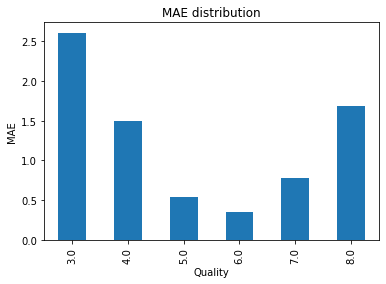

In [27]:
df_results.groupby("real_values")["abs_error"].mean().plot.bar()
plt.title("MAE distribution")
plt.ylabel("MAE")
plt.xlabel("Quality")
plt.show()

The figure above shows that the model has a very poor performance when predicting low and high scores. In the Exploratory Analysis part we have seen that the [distribution of the target variable](#Quality-distribution) - quality - is highly unbalanced. Indeed, most of the wines in the dataset have an intermediate quality score (between 5 and 7). As a consequence, the model does not have enough data to train on all quality scores and poorly performs for the extreme quality values.  

Another thing worth noting is that our assumption regarding the linear relationship might be too strong. Looking at the R^2, we can see that the linear model describes only about 30% of the variance in our data.

# Classification

In this section, we will perform binary and multi-class classification in order to predict the wine color and the quality of the wine.

## Multi-class Classification

We have seen that the linear regression model has a hard time at predicting the quality score because the dataset is highly unbalanced. In this part, we will try to lower the error rate by changing the dataset and making it more balanced. We do this by defining wines as being **bad**, **medium** or **good** depending on their quality score:

- A wine with a quality score of 3 or 4 is **bad** (the dataset doesn't contain wines with quality scores 0,1,2);
- A wine with a quality score of 5 or 6 is **medium**;
- A wine with a quality score of 7,8 or 9 is **good**  (the dataset doesn't contain wines with quality score 10).

We then use logistic regression as the target variable is discrete.

In [28]:
bins = (2,4,6,9)
classes = ['bad', 'medium', 'good']
# Add new column
data['quality_class'] = pd.cut(data['quality'], bins = bins, labels = classes)

In [29]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,quality_class
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,medium
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,medium
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,medium
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,medium
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,medium


In [30]:
# Input features
X = data.drop(columns=['color', 'quality', 'quality_class']).values
# Standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [31]:
# Prepare vector of target quality
y = data["quality_class"].values
y

['medium', 'medium', 'medium', 'medium', 'medium', ..., 'medium', 'medium', 'medium', 'medium', 'medium']
Length: 6497
Categories (3, object): ['bad' < 'medium' < 'good']

The classes are strings, but we need numbers. Therefore, we will do a mapping: **bad** = 3, **medium** = 2, **good** = 1.

In [32]:
mapping = {'bad':3, 'medium':2, 'good':1}
y = np.array([mapping[y_i] for y_i in y])
y

array([2, 2, 2, ..., 2, 2, 2])

In [33]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
# Randomization of the features and targets in the train and test sets
perm = np.random.permutation(len(y))
# Indices of permuted data points
ix_train = perm[:split_point]
ix_test = perm[split_point:]
# Features train set
X_train = X[ix_train,:]
# Features test set
X_test = X[ix_test,:]
# Target train set
y_train = y[ix_train]
# Target test set
y_test = y[ix_test]

print("Number of examples in the train data : %d" % len(y_train))
print("Number of examples in the test data: %d" % len(y_test))

Number of examples in the train data : 4288
Number of examples in the test data: 2209


### Baseline

In [34]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)

# evaluate prediction accuracy
from sklearn.metrics import classification_report
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))
print(classification_report(y_hat, y_test))

Accuracy: 0.7854232684472612
              precision    recall  f1-score   support

           1       0.27      0.58      0.37       197
           2       0.95      0.81      0.87      2011
           3       0.01      1.00      0.02         1

    accuracy                           0.79      2209
   macro avg       0.41      0.79      0.42      2209
weighted avg       0.89      0.79      0.83      2209



### PGM

<center><img src="https://drive.google.com/uc?id=1YXnRYzx6nK6RdeitGEENnQqGs1Hal58w" width = 400>



### Generative process

1. For each class $c \in \{1,..., C\}$:

    a) Draw intercepts $\alpha_{c} \sim \mathcal{N} (\alpha_{c}| 0, \lambda_1) $

    b) Draw coefficients $\boldsymbol \beta_{c} \sim  \mathcal{N}(\boldsymbol \beta_{c}|\boldsymbol 0, \lambda_{2} \boldsymbol I)$

2. For each feature vector $\textbf{x}_n$:

    a) Draw target $y_n \sim$  Multinomial(Softmax($\boldsymbol \alpha + \textbf{B} \textbf{x}_n^T$), where $\textbf{B} = (\boldsymbol \beta_1,...,\boldsymbol \beta_C)$


### STAN model

In [35]:
# define Stan model
model_definition = """

data {
    int<lower=0> N;             // number of data items 
    int<lower=1> D;             // number of predictors
    int<lower=1> C;             // number of classes
    matrix[N,D] X;              // predictor matrix
    int<lower=1,upper=C> y[N];  // classes vector 
}
parameters {
    vector[C] alpha;   // intercepts
    matrix[C, D] beta; // coefficients for predictors 
} 
model {
    for (c in 1:C) {
        alpha[c] ~ normal(0,10); // prior on the intercepts
        beta[c] ~ normal(0,10);  // prior on the coefficients
    }
    for (n in 1:N)
        y[n] ~ categorical(softmax(alpha + beta * X[n]')); // likelihood
}
"""

In [36]:
# Data preparation
N, D = X_train.shape
C = 3 #number of classes = 3 (bad, medium, good)
print("N=%d, D=%d, C=%d" % (N,D,C))
d = {'N': N, 'D': D, 'C': C, 'X': X_train, 'y': y_train}

N=4288, D=11, C=3


In [37]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=d, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_233b86d0b9f8ee6abfbe574956937f40 NOW.


Wall time: 1min 39s


In [38]:
# Prediction
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="vector")
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

y_hat = alpha[:,np.newaxis] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1

# Prediction evaluation
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))
print(classification_report(y_hat, y_test))

Accuracy: 0.7872340425531915
              precision    recall  f1-score   support

           1       0.30      0.58      0.39       216
           2       0.95      0.81      0.87      1992
           3       0.01      1.00      0.02         1

    accuracy                           0.79      2209
   macro avg       0.42      0.80      0.43      2209
weighted avg       0.88      0.79      0.83      2209



The accuracy of this model is relatively high and the error metrics are lower than in the linear regression model.  

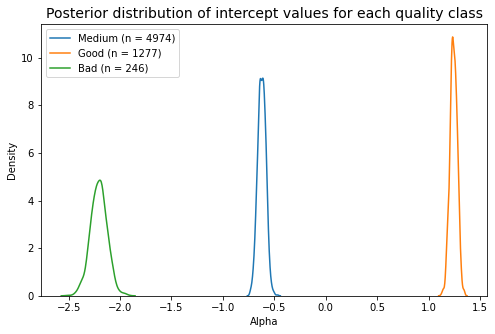

In [39]:
from pystan.external.pymc import plots
samples, means, names = pystan_utils.vb_extract(fit)

plt.figure(figsize = (8, 5))
for i in range(1, 4):
  idx = "alpha[{}]".format(i)
  sns.kdeplot(samples[idx], label = idx)

counts = pd.value_counts(data['quality_class'])
plt.legend(['Medium (n = {})'.format(counts[0]), 'Good (n = {})'.format(counts[1]), 'Bad (n = {})'.format(counts[2])]);

plt.title("Posterior distribution of intercept values for each quality class", fontsize = 14)
plt.xlabel("Alpha")
plt.show()

The figure above shows how certain the model is about the intercept value. As there are a lot of wines with **medium** quality, the certainty is higher.  

<a name = "Binary-classification"></a>
## Binary Classification

In this part of the assignment we will try to build a simple probabilistic model in order to **classify the wines based on their color**. Since we have two colors of wine available in our dataset, it is a **binary classification** task.  
When choosing predictors we were looking at the [plot showing differenes in the chemicals levels between wine colors.](#ColorPlot) We decided to use the ones with the **highest difference**. We omitted `free sulfur dioxide` as we assumed it is correlated with `total sulfur dioxide` so including it would not add any "new prediction power" as they both would explain the similar things. Thus, the resulting inputs are **5-dimensional**.

In [136]:
features = ['volatile acidity', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'sulphates']
X = data[features]
X_std = (X - np.mean(X))/np.std(X)
y = data['color']
y = (y == 'red').astype(int) # 1 if color is red

We can see that our dataset is a bit **unbalanced**, as we have three times more data points that describe white wines. That is why it is important to use a stratified split to ensure that the proprtions of classes in a training set are the same as in a test set.

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.25, random_state = 42, shuffle = True, stratify = y)
print("Share of white wines in the training and test set respectively: {}, {}.".format(round(sum(y_train == 0)/len(y_train), 2), round(sum(y_train == 1)/len(y_train), 2)))
print("Share of red wines in the training and test set respectively: {}, {}.".format(round(sum(y_test == 0)/len(y_test), 2), round(sum(y_test == 1)/len(y_test), 2)))

Share of white wines in the training and test set respectively: 0.75, 0.25.
Share of red wines in the training and test set respectively: 0.75, 0.25.


### Sklearn baseline

In order to have some baseline that we can compare our results to, we build a simple logistic regression model using `sklearn` module. Because the accuracy is very high (~ 98%), we do not expect our STAN model to significantly outperform the baseline.

In [138]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Baseline accuracy:", round(lr.score(X_test, y_test), 5))

Baseline accuracy: 0.98092


### PGM

<img src="https://drive.google.com/uc?id=1Jwa2W_g1PK3-Nq-n6V-5A6Eih-cm8ZnV" width = 400>


### Generative process

1. Draw intercept $\alpha \sim \mathcal{N}(\alpha | 0, \lambda)$.
2. Draw coefficients $\boldsymbol\beta \sim \mathcal{N}(\boldsymbol\beta | \boldsymbol0, \lambda \boldsymbol I)$.
3. For each observation $n$:  
  a) Draw target $y_n \sim \mathcal{Bernoulli}(y_n | sigmoid(\alpha + \boldsymbol\beta^T \textbf{x}_n))$.

### STAN model

It is time to build a STAN model.

In [139]:
model = """
data {
    int<lower=0> N;     // number of training data points
    int<lower=0> D;     // number of predictors
    int<lower=0> C;     // binary classification, C = 1
    matrix[N, D] X;
    int y[N];
}
parameters {
    vector[C] alpha;    // intercept
    matrix[C, D] beta;  // predictors coefficients
}
model {
    
    matrix[N, C] x_beta = X*beta';   
    to_vector(beta) ~ normal(0, 1); //vector of length D*C, prior of betas
    
    alpha ~ normal(0, 1); // prior of the intercept
    
    for (n in 1:N)    
        y[n] ~ bernoulli(Phi(alpha + x_beta[n,:]'));      // probit regression
        //y[n] ~ bernoulli_logit(alpha' + X[n,:]*beta');  // sigmoid
}
"""

In [140]:
N, D = X_train.shape
C = 1
d = {'N': N, 'D': D, 'C': C, 'X': X_train, 'y': y_train}

In [141]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5a501dfd06d38181b8f1c6cce98f0dd8 NOW.


CPU times: user 1.65 s, sys: 120 ms, total: 1.77 s
Wall time: 1min 7s


We use **Markov chain Monte Carlo which utilizes no-U-turn sampler** algorithm to draw samples from the posterios distribution.

In [142]:
%%time
fit = sm.sampling(data = d, iter = 1000, chains = 4, algorithm = "NUTS", seed = 42, verbose = True)

CPU times: user 415 ms, sys: 84 ms, total: 499 ms
Wall time: 1min 4s


In [143]:
print(fit)

Inference for Stan model: anon_model_5a501dfd06d38181b8f1c6cce98f0dd8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   -1.98  2.1e-3   0.08  -2.14  -2.03  -1.98  -1.92  -1.83   1396    1.0
beta[1,1]   0.97  1.2e-3   0.06   0.86   0.93   0.97    1.0   1.07   2031    1.0
beta[1,2]  -0.31  2.2e-3   0.09  -0.49  -0.37  -0.31  -0.25  -0.14   1696    1.0
beta[1,3]  -1.61  1.7e-3   0.07  -1.76  -1.66  -1.61  -1.56  -1.47   2002    1.0
beta[1,4]   0.67  9.2e-4   0.05   0.58   0.64   0.67    0.7   0.76   2439    1.0
beta[1,5]    0.7  1.1e-3   0.05    0.6   0.67    0.7   0.74   0.81   2374    1.0
lp__      -384.4    0.06    1.7 -388.6 -385.3 -384.0 -383.1 -382.1    777    1.0

Samples were drawn using NUTS at Thu May 27 10:19:55 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale re

From the summary above, it is clear that the model is valid.  
The Rhat statistic (called **potential scale reduction statistic**) measures the ratio of the average variance of the draws within each chain to the variance of the pooled draws across chains [3]. This is a way to monitor whether a chain has converged to the equilibrium distribution (so that the distribution of samples from chains should be the same regardless of the initial starting values of the chains). If the chains converged to the common distribution, then Rhat is equal to one, otherwise it will be greater than one. In this particular case, every parameter in the model has Rhat equal to one and therefore, there is no need to increase the number of iterations. However, it must be noted that this is a **necessary but not sufficient condition for convergence**.  

Another difficulty posed by MCMC methods is that the samples may be **correlated within a chain**, which increases the uncertainty of the posterior distribution. The amount by which autocorrelation within the chains increases uncertainty in estimates can be measured by **effective sample size (ESS)** [4], which is the number of **effectively independent draws from the posterior distribution**. Given that the number of post-warmup draws is 2000, we can conclude that having ESS at the level of around 1700 is a good indicator of the model's reliability. What's interesting, for beta[1, 1], the **n_eff statistic is greater than 2000**. It is possible and it happens for parameters which have **close to Gaussian posterior and little dependency on other parameters** [4].

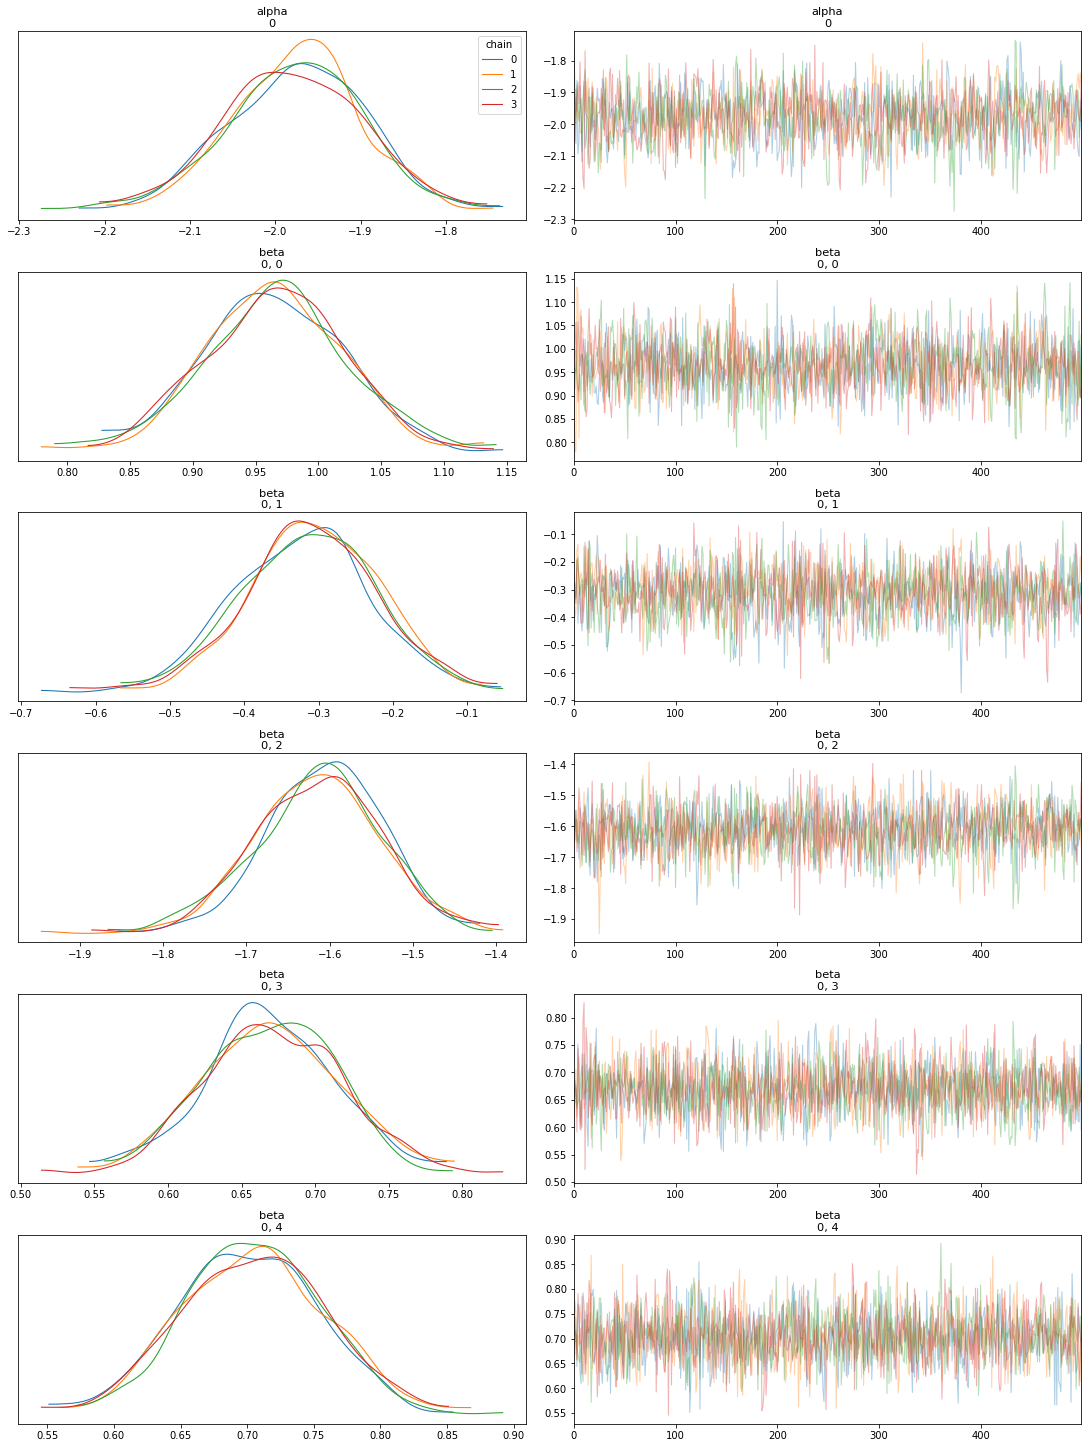

In [144]:
#!pip install arviz
import arviz
arviz.plot_trace(fit, legend = True, compact=False, figsize = (15, 20));

In the plot above we can take a look at the trace plot, which can tell us how well the sample is exploring the space of the posterior distribution. In general, for every parameter, the **trace plots are well-behaved**. They basically look like **random noise jumping around a relatively constant number**. The chains are all on top of each other and look like they are drawn from the same distribution. There is no indication of the autocorrelation.

In [148]:
# Prediction
samples = fit.extract(permuted=True) 
mu = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].reshape(2000, 5).T), axis=1)
y_hat = (mu > 0).astype("int")

# Prediction evaluation
print("Accuracy:", np.sum(y_hat == y_test) / len(y_test))

Accuracy: 0.9815384615384616


As a result we got very high accuracy, even slightly higher than the baseline's accuracy.

We can also use the `arviz` module to plot posterior distributions of our latent variables with the most important statistics highlighted like the 94% **High Density Interval** which could be used in the context of uncertainty characterisation. We can also choose whether we want to see the mean, mode or median of the distributions.

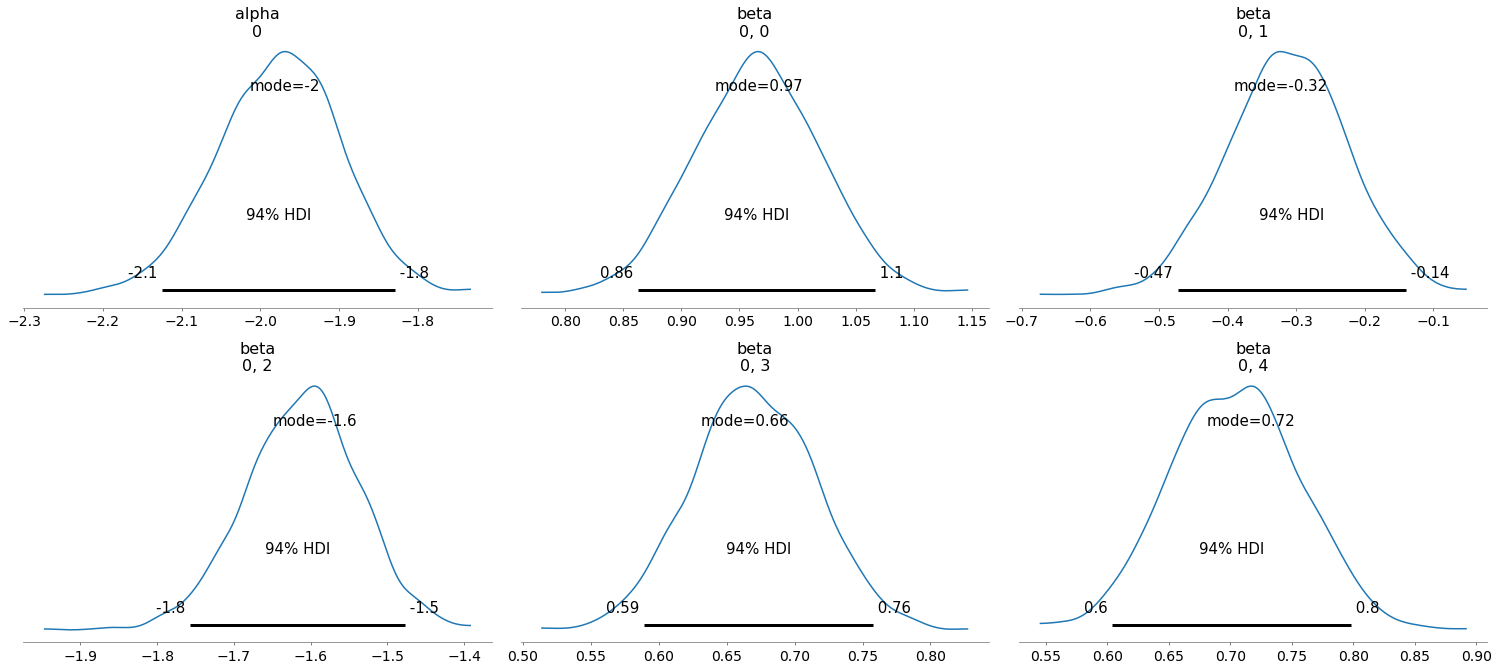

In [149]:
arviz.plot_posterior(fit, point_estimate = 'mode');

From this we can see that the model is generally certain about the **kind of influence** (negative/positive) the features have on the probability of wine being red. That is, for all of them, the HDI includes either only positive or only negative values. Thus, **higher levels of `volatile acidity`, `sulphates` and `chlorides`** increase the probability of wine being **red** and **higher levels of `residual sugar` and `total sulfur dioxide`** increase the chances that the wine is **white**.

## Hierarchical model

In this section we will present a **hierarchical model** which is used to predict color of the wine taking into account its **sweetness**. In the previous example we treated all kind of wines the same way, assigning **the same importance** to all features and the same bias (**complete pooling** scenario).  

Now we will distinguish between **dry, semi dry and semi sweet wines** and build a model that understands the difference between them. This means that the model's parameters will now **vary between the types**. An extreme approach to this task would be to model each of the types **independently**, assigning them their own coefficients that are estimated separetely from others (**no pooling** scenario).  

A hierarchical model (**partial pooling**) is an approach that is in between these two extremes. In this case we assume that all the weights come from some **higher level distribution that is the same for each of them** and is controlled by some parameters. The parameters that control the distribution of other unobserved parameters and not the distribution of observed measurments are called **hyperparameters** and the prior that we put on them is called **hyperprior**. In this case the degree of pooling is determined by the data and specified by the prior on the amount of pooling.  This way we can **fight overfitting** because the parameters are not solely dependent on the observations from each type of wine but also on the observations of the remaining types through the higher-level prior.

In [150]:
# Dropping one outlier with sugar > 63
data = data.drop(2781)

In [152]:
data['wine_type_by_sugar'] = 0
for i in range(len(data)):
  if data.iloc[i,3].astype(float) < 4.0:
    data.iloc[i, 13] = 'dry'
  elif data.iloc[i,3] < 12:
    data.iloc[i, 13] = 'semi dry'
  elif data.iloc[i,3] < 45:
    data.iloc[i, 13] = 'semi sweet'

mapper = {'dry': 1, 'semi dry': 2, 'semi sweet': 3}
data['type_encoded'] = data['wine_type_by_sugar'].replace(mapper)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,wine_type_by_sugar,type_encoded
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,semi sweet,3
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,dry,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,semi dry,2
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,semi dry,2
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,semi dry,2


### Varying intercept

This model allows intercepts to vary across wine types but the slope is fixed:

\begin{align}
y_{i} = Bernoulli(\frac{1}{1+e^{-z}}), \ \ \ z = \alpha_{ji} + \beta x_{i} + \epsilon_{i}, \ \ \ \epsilon_i \sim N(0,\sigma^{2}_{y}).
\end{align}

and the intercept is distributed as:
\begin{align}
\alpha_{ji} \sim N(\mu_{\alpha}, \sigma^{2}_{\alpha}).
\end{align}

So here $\mu_{\alpha}$ (a hyperparameter) represents the overall **population average** intercept, while $\alpha_{ji}$ are the **wine-type-specific** intercepts. The same holds for $\sigma^{2}_{y}$, which is the **within-wine-type** variability, while $\sigma^{2}_{\alpha}$ is the **between-wine-type** variability.





#### PGM

<center><img src="https://drive.google.com/uc?id=1OO7XwZIIIyoPDaZ5WXaUnHJTdedrcMei"></center>

#### Generative process



1. Draw global mean parameter $\mu_{\alpha} \sim N(\mu_{\alpha}|0, 5)$.
2. Draw global variance parameter $\sigma_{\alpha} \sim Cauchy(\sigma_{\alpha}|0, 5)$.
3. For each sugar level $l$:  
  a) Draw intercept $\alpha_{l} \sim N(\alpha_{l}|\mu_{\alpha}, \sigma_{\alpha})$.
4. For each feature vector $\textbf{x}_n$:
  a) Draw class $y_n \sim Bernoulli(y_n|sigmoid(\alpha_l + \beta \textbf{x}_n))$.

We put **less informative priors** on the hyperparameters to allow for a certain amount of pooling. If we were to choose a much higher value of $\sigma$, the **Gaussian would be flat** and all values of $\mu$ would be **equally likely**, which would correspond to the extreme with no pooling at all. We chose the **half-Cauchy distribution for $\sigma$** instead of a half-Guassian, because it has slightly fatter tails which means putting more weight on higher values. Someone could argue that putting highest prior probability to zero for variance parameter seems unreasonable but this way we may **favor simpler explanations** and penalize complex ones.

#### STAN model

In [153]:
features = ['volatile acidity', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'sulphates', "type_encoded"]
X = data[features]
y = data['color']
y = (y == 'red').astype(int) # 1 if color is red

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle = True, stratify = y)
type_encoded_train = X_train['type_encoded']
type_encoded_test = X_test['type_encoded']

# Standardization
X_train = (X_train.iloc[:,:-1] - np.mean(X_train.iloc[:,:-1]))/np.std(X_train.iloc[:,:-1]) # exclude type_encoded from standardization
X_test = (X_test.iloc[:,:-1] - np.mean(X_test.iloc[:,:-1]))/np.std(X_test.iloc[:,:-1])

In [155]:
# Data preparation
N, D = X_train.shape
C = 1
L = 3
print("N = %d, D = %d, C = %d, L = %d" % (N,D,C,L))
d = {'N': N, 'D': D, 'C': C, 'L':L, 'sugar_level':type_encoded_train.values, 'X': X_train, 'y': y_train}

N = 4872, D = 5, C = 1, L = 3


In [156]:
hierarchical_model_intercept = """
data {
    int<lower=0> N;             
    int<lower=1> D;             
    int<lower=1> C;             
    int<lower=1> L;                               // number of sugar levels
    int<lower=1,upper = L> sugar_level[N];        // information about the sugar level
    matrix[N,D] X;              
    int<lower=0,upper=1> y[N];  
}
parameters {
    real mu_prior;      
    real<lower=0> sigma_prior;
    vector[L] alpha;              // intercepts (biases) for each individual
    vector[D] beta;               // coefficients for predictors
} 
model {
    mu_prior ~ normal(0, 5);      // hyper-prior on the intercepts mean
    sigma_prior ~ cauchy(0, 5);   // hyper-prior on the intercepts variance
    beta ~ normal(0, 1);          // prior on the coefficients
    for (l in 1:L) {
        alpha[l] ~ normal(mu_prior, sigma_prior);
    }
    for (n in 1:N) {
        y[n] ~ bernoulli_logit(alpha[sugar_level[n]] + X[n] * beta); // likelihood
    }
}
"""
# create Stan model object
sm = pystan.StanModel(model_code = hierarchical_model_intercept)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f361a31a11c83a11af42bf306fc2f94a NOW.


In [157]:
%%time
fit_H_I = sm.vb(data = d, iter = 20000, algorithm = "meanfield", seed = 42, verbose=True)

CPU times: user 2.08 s, sys: 35.7 ms, total: 2.12 s
Wall time: 2.12 s


In [158]:
mu_prior = pystan_utils.vb_extract_variable(fit_H_I, "mu_prior", var_type="vector")[0]
sigma_prior = pystan_utils.vb_extract_variable(fit_H_I, "sigma_prior", var_type="vector")[0]
alpha = pystan_utils.vb_extract_variable(fit_H_I, "alpha", var_type="matrix", dims = (C, L))
beta = pystan_utils.vb_extract_variable(fit_H_I, "beta", var_type="matrix", dims = (C, D))[0]
print("Alpha:", alpha[0], "\nBeta: ", beta)
print("Mu_prior:", mu_prior, "\nSigma prior:", sigma_prior)

Alpha: [-2.85117276 -5.06245498 -6.83833833] 
Beta:  [ 1.93248624  0.79385571 -3.21568629  1.36718023  1.31650399]
Mu_prior: -4.443528055652683 
Sigma prior: 2.5231889210140452


In [159]:
# Predictions for test set
y_hat = alpha[:,type_encoded_test-1] + np.dot(beta, X_test.T)
y_hat = y_hat[0]
y_hat = (y_hat > 0).astype("int")

print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Accuracy: 0.9852216748768473


Let's plot the posterior distributions of some of the model's parameters.

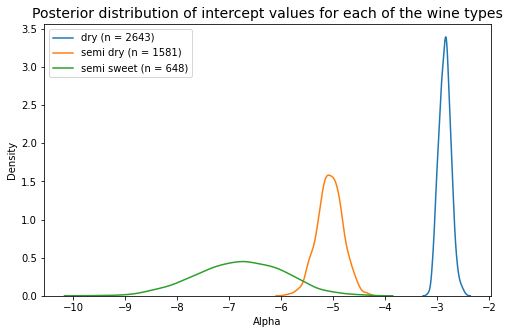

In [160]:
from pystan.external.pymc import plots
samples, means, names = pystan_utils.vb_extract(fit_H_I)

plt.figure(figsize = (8, 5))
for i in range(1, 4):
  idx = "alpha[{}]".format(i)
  sns.kdeplot(samples[idx], label = idx)

plt.title("Posterior distribution of intercept values for each of the wine types", fontsize = 14)
plt.xlabel("Alpha");

counts = pd.value_counts(type_encoded_train)
plt.legend(['dry (n = {})'.format(counts[1]), 'semi dry (n = {})'.format(counts[2]), 'semi sweet (n = {})'.format(counts[3])]);

Looking at the above plot we can clearly see how the **certainty about intercept value decreases with the number of data points**. In our dataset we have most of dry wines and the model is quite certain about this type, but for semi sweet wines a lot of values from range -9 to -6 may be considered.

In [161]:
coeff = pd.DataFrame(data = [X_train.columns, beta]).T
coeff.columns = ['Feature name', 'Coefficient']
coeff = coeff.set_index('Feature name')
coeff = coeff.sort_values(by = 'Coefficient', ascending = False)
coeff

,Coefficient
Feature name,
volatile acidity,1.93249
chlorides,1.36718
sulphates,1.3165
residual sugar,0.793856
total sulfur dioxide,-3.21569


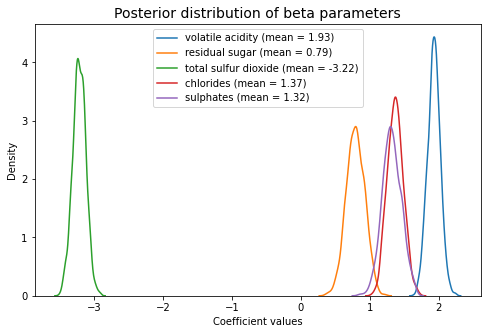

In [162]:
plt.figure(figsize = (8, 5))
for i in range(1, D+1):
  idx = "beta[{}]".format(i)
  sns.kdeplot(samples[idx], label = idx)
plt.title("Posterior distribution of beta parameters", fontsize = 14)
plt.xlabel("Coefficient values");

l = []
for i in range(len(X_train.columns)):
  l.append("{} (mean = {})".format(X_train.columns[i], round(beta[i], 2)))
plt.legend(l);

The model is equally certain about all of the coefficients for our features. It indicates that **`total sulfur dioxide`** is the variable that most significantly contributes to the white color of the wine. There is a difference between the previous simple binary classification model as this one claims that **`residual sugar` positively affects that probability of wine being red**. However, as with the previous model, in that case the **magnitude of this coefficient is also the smallest**.

### Varying intercept and slope

In this section we will also investigate whether allowing for **separate slopes for each of the wine types** along with the varying intercept will improve the fit:  

\begin{align}
y_i = \alpha_{ji} + \beta_{ji}x_i + \epsilon_i.
\end{align}



#### PGM

<center><img src="https://drive.google.com/uc?id=18qM0e08TmMqsQOSJMOUP5shOhEruDtmP" width = 400>

#### Generative process

1. Draw hyper prior mean for intercept $\mu_{\alpha} \sim N(\mu_{\alpha}|0, 5)$.
2. Draw hyper prior variance for intercept $\sigma_{\alpha} \sim Cauchy(\sigma_{\alpha}|0, 5)$.
3. Draw hyper prior mean for slope $\mu_{\beta} \sim N(\mu_{\beta}|0, 5)$.
4. Draw hyper prior variance for slope $\sigma_{\beta} \sim Cauchy(\sigma_{\beta}|0, 5)$.
5. For each sugar level $l$:  
  a) Draw intercept $\alpha_{l} \sim N(\alpha_{l}|\mu_{\alpha}, \sigma_{\alpha})$.  
  b) Draw slope parameter $\beta_{l} \sim N(\beta_{l}|\mu_{\beta}, \sigma_{\beta})$.
6. For each feature vector $\textbf{x}_n$:  
  a) Draw class $y_n \sim Bernoulli(y_n|sigmoid(\alpha_l + \beta_l \textbf{x}_n))$.

#### STAN model

In [163]:
hierarchical_model_slope_intercept = """
data {
    int<lower=0> N;             
    int<lower=1> D;             
    int<lower=1> C;             
    int<lower=1> L;                               // number of sugar levels
    int<lower=1,upper = L> sugar_level[N];        // information about the sugar level
    matrix[N,D] X;              
    int<lower=0,upper=1> y[N];  
}
parameters {
    real mu_prior_a;      
    real<lower=0> sigma_prior_a;
    real mu_prior_b;      
    real<lower=0> sigma_prior_b;

    vector[L] alpha;                              // intercepts (biases) for each individual
    matrix[L, D] beta;                            // coefficients for predictors
} 
model {
    mu_prior_a ~ normal(0, 5);                    // hyper-prior on the intercepts mean
    sigma_prior_a ~ cauchy(0, 5);                 // hyper-prior on the intercepts variance
    
    mu_prior_b ~ normal(0, 5);                    // hyper-prior on the coeffcients mean
    sigma_prior_b ~ cauchy(0, 5);                 // hyper-prior on the coefficients variance

    for (l in 1:L) {
        alpha[l] ~ normal(mu_prior_a, sigma_prior_a);
        beta[l,:] ~ normal(mu_prior_b, sigma_prior_b);
    }
    for (n in 1:N) {
        y[n] ~ bernoulli_logit(alpha[sugar_level[n]] + X[n] * beta[sugar_level[n],:]'); // likelihood
    }
}
"""
# create Stan model object
sm = pystan.StanModel(model_code = hierarchical_model_slope_intercept)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e4d80349396c1514d4cd3ffb4a01ec7b NOW.


In [164]:
%%time
fit_H_I_S = sm.vb(data = d, iter = 20000, algorithm = "meanfield", seed = 42, verbose=True)

CPU times: user 3.34 s, sys: 63.6 ms, total: 3.4 s
Wall time: 3.38 s


In [165]:
mu_prior_a = pystan_utils.vb_extract_variable(fit_H_I_S, "mu_prior_a", var_type="vector")
sigma_prior_a = pystan_utils.vb_extract_variable(fit_H_I_S, "sigma_prior_a", var_type="vector")
mu_prior_b = pystan_utils.vb_extract_variable(fit_H_I_S, "mu_prior_b", var_type="vector")
sigma_prior_b = pystan_utils.vb_extract_variable(fit_H_I_S, "sigma_prior_b", var_type="vector")

alpha = pystan_utils.vb_extract_variable(fit_H_I_S, "alpha", var_type="matrix", dims = (C, L))
beta = pystan_utils.vb_extract_variable(fit_H_I_S, "beta", var_type="matrix", dims = (L, D))

print("Alpha:", alpha[0], "\nBeta: ", beta)
print("\nMu_prior_alpha:", mu_prior_a, "\nSigma_prior_alpha:", sigma_prior_a)
print("\nMu_prior_beta:", mu_prior_b, "\nSigma_prior_beta:", sigma_prior_b)

Alpha: [-1.65818838 -4.48937549 -3.44677819] 
Beta:  [[ 2.09243983  2.74394517 -3.5579758   1.68488037  1.40816968]
 [ 1.69772394  0.15820845 -2.83317623  1.25982788  1.55820638]
 [ 0.52912323 -0.93765287 -2.10624972  0.74898212  0.89119542]]

Mu_prior_alpha: [-3.13002416] 
Sigma_prior_alpha: [2.41950283]

Mu_prior_beta: [0.31113483] 
Sigma_prior_beta: [2.1218545]


In [166]:
# Predictions for test set
y_hat = alpha[:,type_encoded_test-1] + np.dot(beta[type_encoded_test-1,:], X_test.T)
y_hat = y_hat[0]
y_hat = (y_hat > 0).astype("int")

print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Accuracy: 0.9759852216748769


Although the accuracy is still very high, the model performed **slightly worse** compared to the previous one, where only the intercept was varying across the types. Additionally, it also did not outperform sklearn baseline.

How does the posterior distributions of $\beta$ parameters of our model look like?

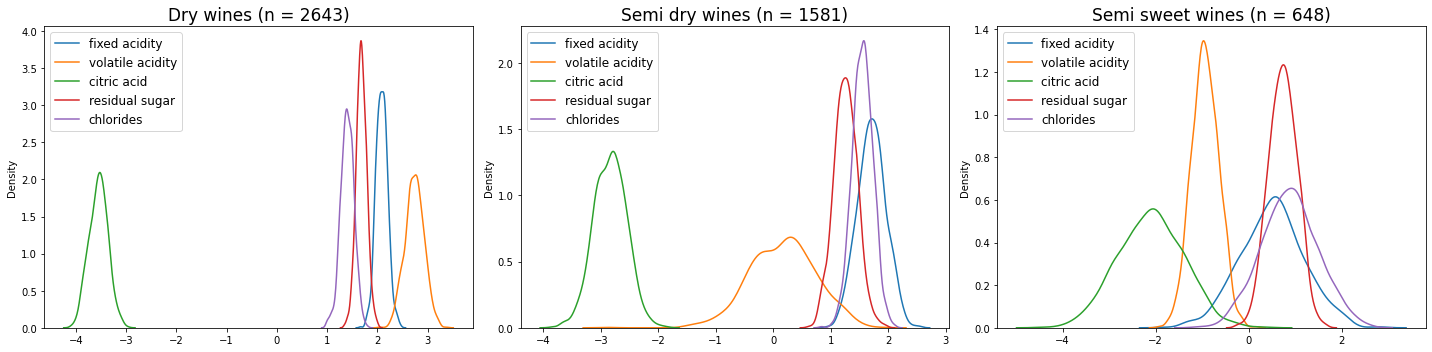

In [198]:
# Extract samples
samples, means, names = pystan_utils.vb_extract(fit_H_I_S)
beta_1 = []; [beta_1.append(samples[idx]) for idx in names if idx[:6] == 'beta[1']
beta_2 = []; [beta_2.append(samples[idx]) for idx in names if idx[:6] == 'beta[2']
beta_3 = []; [beta_3.append(samples[idx]) for idx in names if idx[:6] == 'beta[3']
betas = np.array([beta_1, beta_2, beta_3])

# Plot distributions
titles = ["Dry wines", "Semi dry wines", "Semi sweet wines"]

plt.figure(figsize = (20, 5))
for i in range(1, 4):
  plt.subplot(1, 3, i)
  beta_to_plot = betas[i-1,:,:]
  for j in range(0, 5):
    sns.distplot(beta_to_plot[j,:], hist = False)
  plt.title("{} (n = {})".format(titles[i-1], counts[i]), fontsize = 17)
  plt.legend(X_train.columns, fontsize = 12)
  plt.tight_layout()
  plt.savefig("Varying_slope.png")

Here we can again see how the model is certain about the parameters for the wine types with more observations (dry wines) than for the ones with the smallest number of data points. Furthermore, for sweet wines, for some features (for example `volatile acidity` or `sulphates`), **mode of the posteriors is close to 0**, which means that the effect on the probability of wine being red is not certain (there is a considerable weight on the negative values as well).  
What is also interesting to see here is that for semi dry wines, the model is "lost" when it comes to estimating the coefficient of `residual sugar`.  
Below presented are also the **posteriors of hyperparameters**.

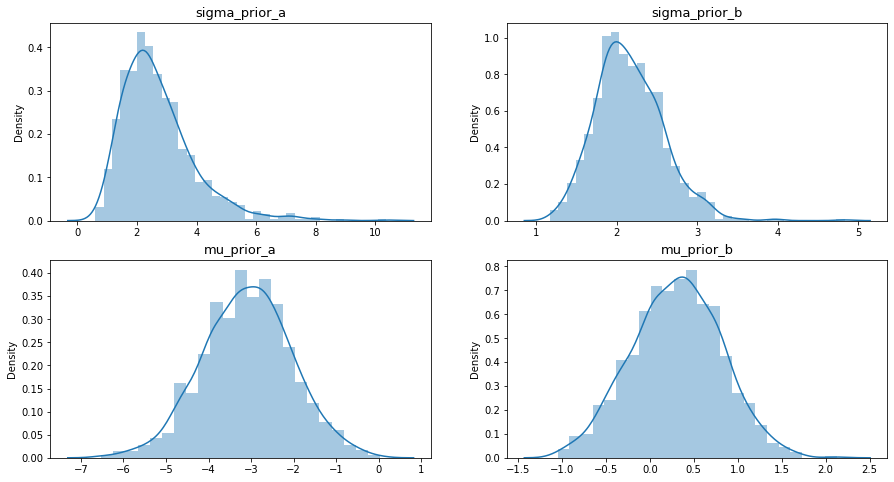

In [168]:
params = ['sigma_prior_a', 'sigma_prior_b', 'mu_prior_a', 'mu_prior_b']
k = 1
plt.figure(figsize = (15, 8))
for i in range(len(params)):
  plt.subplot(2, 2, k)
  sns.distplot(samples[params[i]])
  plt.title(params[i], fontsize = 13)
  k += 1

# Gaussian processes

In this section we would like to present a **non-parametric** approach to the problem of binary classification, where the predictions are in a form of probabilities. In this type of classification we would like to estimate the following response probability function:  

\begin{align}
p(x) = P(Y = 1| X = x). 
\end{align}

Traditionally, in a parametric approach we would specify the function $p$ using the following model:  

\begin{align}
p(x) = H(\alpha + \beta^{T}x),  
\end{align}

where $\alpha$ and $\beta$ are unknown **parameters** and $H$ is a **link function**. A typical choice for $H$ could be the standard logistic cumulative distribution function but there is also a very close alternative to it - probit regression which uses standard normal cdf $\Phi$. However, whatever the function of interest, the inference is sensitive to the choice of $H$ [5]. Additionally, a **linear relationship is assumed between the inputs and outputs**. In cases where this assumption is too strong and the relationship cannot be reasonably approximated by a linear function, the model will give poor predictions.  
Hence, it may be beneficial to avoid these assumptions and take a non-parametric method, where we do not consider parameters that will need to do their best to fit the data.  

Gaussian processes are a non-parametric approach in that they find a distribution over the possible functions $f(x)$ that are consistent with the observed data. It means that we no longer consider parameters but a set of functions that match our data with however many parameters are involved [6]. Thus, *non-parametric* does not mean that there are no parameters, but that there is an infinite number of parameters.  
In order to somehow constrain them we should specify a **prior** over the **latent function $f(x)$**, which is needed when we do not have any training (observed) data points. Initially, we assume that it **revolves around 0**. Additionally, we would like it to be rather **smooth**. This aspect, along with periodicity, stationarity and isotropy, is controlled by a **covariance matrix $K$**, which ensures that the inputs that are similar to each other will produce outputs that are also similar. Thus, GP is fully specified by a mean function $m(x) = E[f(x)]$ and a positive definite covariance function $k(x, x_{*}) = cov[f(x), f(x_{*})]$. So the prior can be defined as follows:  

\begin{align}
p(\textbf{f}) = N(\textbf{f}|\textbf{0}, \textbf{K})
\end{align}

A covariance function greatly impacts the inference and prediction results of the GP model. Its entries are defined by a **kernel**, which receives two points: $x$ and $x_{*}$ and **returns their similarity** in the form of scalar [6]. A popular choice is the **squared-exponential (SE)** (a.k.a. exponentiated quadratic covariance function or Radial Basis Function (RBF) kernel), which is given by the following equation and will be used in this project:  

\begin{align}
cov(f, f_{*}) = k(x, x^{*}) = \alpha^{2}exp(-\frac{1}{2l^{2}}\sum_{d=1}^D (x_{d} - x^{*}_{d})^{2}),
\end{align}

where:
* $D$ is the input dimension,
* $\alpha$ is the average distance from the function's mean,
* $l$ is the length scale which represents the reach of influence on neighbors.  

It is important to note that in this model we assign **common value of $l$** for each of the input dimensions. This aspect will be further discussed in the next section.

The inference is done in the following way. First, we specify the posterior distribution over the latent function value $f_{*}$ evaluated at a new point $x_{*}$, conditionall on the training data [7]:

\begin{align}
p(f_{*}|\textbf{X}, \textbf{y}, \textbf{x}_{*}) = \int{p(f_{*}|\textbf{X}, \textbf{x}_{*}, \textbf{f}) p(\textbf{f|X, y}) d\textbf{f}},
\end{align}

where the posterior over the latent variables can be obtained by using a **Bayes' rule** [7]:

\begin{align}
p(\textbf{f|X, y}) = \frac{p(\textbf{y|f}) p(\textbf{f})}{p(\textbf{y|X})}.
\end{align}

To obtain the probability of class membership, we integrate over the logistic function and the posterior distribution for $f_*$:

\begin{align}
p(y = 1| \textbf{x}_{*}) = \int{H(f_{*}) p(f_{*}|\textbf{X}, \textbf{y}, \textbf{x}_{*})df_{*}},
\end{align}

While in case of a regression problem **all distributions are Gaussian** and therefore all integrals can be treated analytically, this does not hold for a classification problem, where the Gaussian likelihood for targets being discrete class labels in **inappropriate** [8]. In this situation the inference is no longer tractable and we must resort to **approximate methods**.  

## PGM

<center><img src="https://drive.google.com/uc?id=1w87YIPMVhmq8WFZbix048fJrOCzYsT6y"></center>

As discussed above, $\alpha$ and $l$ are parameters of the covariance function which specifies the GP prior over the latent function values $f$. They are point estimates that maximize the log of marginal likelihood of our data [10].  
In our implementation we included two additional parameters: $a$ and $\eta$. The first one is just a **bias term**, which should help us deal with the imbalanced classes in our data (around 75% of observations are white wines and 25% are red). The latter one, $\eta$, is used to **multiply the Cholesky factor** of the covariance matrix so that $f$ is implicitly distributed as a **multivariate normal random variable**, which is called **non-centered parameterization of a multivariate normal** [9].

## Generative process

1. Draw length scale $l \sim Inv\_Gamma(l|5, 5)$.  
2. Draw output variance $\alpha \sim N(\alpha|0, 5)$.  
3. Draw $a \sim N(a|0, 1)$.  
4. Draw $\eta \sim N(\eta|0, 1)$.  
5. Calculate $f = Cholesky\_decompose(SE(\textbf{x}, \alpha, l)) * \eta$.  
6. For each observation $n$:  
    a) $y_n \sim \mathcal{Bernoulli}(y_n | sigmoid(a + f_n))$.

According to Stan's User Guide and the section about prior recommendations for GP [11], we put an **inverse gamma** distribution prior on the length scale as it puts negligible mass on the very small values, but at the same time it is characterized by a **considerable right tail** which still allows for larger length scales, as demonstrated below. It is also a **boundary-avoiding distribution**, where the density at zero is zero [11].

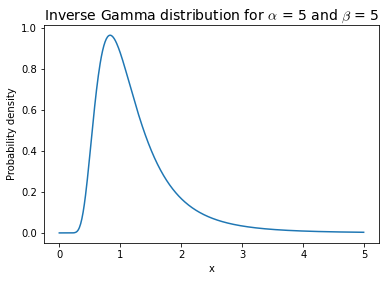

In [169]:
from scipy.stats import invgamma

a = 5    # shape
x = np.arange(0, 5, 0.01)
rv = invgamma(a, scale = 5)
plt.plot(x, rv.pdf(x))
plt.title(r"Inverse Gamma distribution for $\alpha$ = 5 and $\beta$ = 5", fontsize = 14);
plt.xlabel("x"); plt.ylabel("Probability density");

As for the $\alpha$, which is a scaling factor of the covariance function that determines variation of values from their mean, we put a **less informative half-Gaussian** prior centered around $\mu = 0$ and a standard deviation equal to 5. The remaining two parameters have a standard normal distribution as a prior.

## Implementation in STAN

In the below model we put $f$ into the transformed parameters block. The reason for this is that it removes the prior dependence of the density of $f$ on $\alpha$ and the length scale. When the data are weakly informative about $f$, this can aid in sampling efficiently from the joint posterior [9].  

Additionally, what also can be noted, is that we add a **small positive constant $\delta$** to the **diagonal of the covariance matrix**. Although we use a positive definite covariance function to build the covariance matrix $K$, a small dimension will typically not be numerically positive definite because we deal with floating point numbers [9]. Thus, a bit of **jitter** is added to the diagonal to ensure it is indeed positive.

In [170]:
gaussian_processes = """ 
data {
    int<lower=1> D;

    int<lower=1> N_train;
    vector[D] x_train[N_train];            //array of vectors
    int<lower=0, upper=1> y_train[N_train];

    int<lower=1> N_test;
    vector[D] x_test[N_test];              //array of vectors
}

transformed data {
    real delta = 1e-9;                     // small positive term that needs to be added to the diagonal of 
                                           // covariance matrix to ensure that it is positive
    int<lower=1> N = N_train + N_test;
    vector[D] x[N];
    for (n in 1:N_train) x[n] = x_train[n];
    for (n in 1:N_test) x[N_train + n] = x_test[n];
}
parameters {
    real<lower=0> length_scale;            // scale at which distances are measured among inputs
    real<lower=0> alpha;                   // scale of the output values, half-normal
    real a;                                // bias term
    vector[N] eta;                         // vector of univariate normals
}
transformed parameters {
    vector[N] f;
    {
        matrix[N, N] L_K;
        matrix[N, N] K = cov_exp_quad(x, alpha, length_scale);  // function that implements the exponentiated quadratic kernel
        
        // diagonal elements
        for (n in 1:N)
            K[n, n] = K[n, n] + delta;
            
        L_K = cholesky_decompose(K);
        f = L_K * eta;                     // non-centered parameterization of a multivariate normal
    }
} 
model {
    length_scale ~ inv_gamma(5, 5);
    alpha ~ normal(0, 5);
    a ~ std_normal();
    eta ~ std_normal();

    y_train ~ bernoulli_logit(a + f[1:N_train]);
}
generated quantities {
    int<lower=0, upper=1> y_pred[N_test];
    for (n in 1:N_test)
        y_pred[n] = bernoulli_logit_rng(a + f[N_train + n]);
}
"""

# Compile Stan model
sm = pystan.StanModel(model_code = gaussian_processes)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0fef82b7a4b7a9deb525fa76b50065bf NOW.


For this task we chose 5 features that have the highest differences in the chemical levels between the wine colors, as shown in [this plot](#ColorPlot), omitting the *free sulfur dioxide* for the reasons described in the [Binary Classification](#Binary-classification) section.  
Due to the computational overhead, **we reduced our dataset to 1200 observations**, out of which 900 are training points and 300 are used to validate the model.

In [171]:
features = ['volatile acidity', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'sulphates']
data = data[data['residual sugar'] < 63].copy()
data_sampled = data.sample(1200)
X = data_sampled[features]
y = data_sampled['color']
y = (y == 'red').astype(int) # 1 if color is red

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle = True, stratify = y)

X_train = (X_train - np.mean(X_train))/np.std(X_train)
X_test = (X_test - np.mean(X_test))/np.std(X_test)

In [172]:
# Data preparation
N_train, D = X_train.shape
N_test = X_test.shape[0]
print("N_train = %d, N_test = %d, D = %d" % (N_train, N_test, D))
d = {'N_train': N_train, 'N_test': N_test, 'D': D, 'x_train': X_train, 'x_test': X_test, 'y_train': y_train}

N_train = 900, N_test = 300, D = 5


After some initial trials, we estimated that 1500 number of iterations should be enough for the ELBO to converge.

In [173]:
%%time
fit_GP = sm.vb(data = d, iter = 1500, algorithm = "meanfield", seed = 42, output_samples = 1, verbose=True) 

CPU times: user 16min 59s, sys: 9.38 s, total: 17min 9s
Wall time: 17min 2s


In [174]:
y_pred = pystan_utils.vb_extract_variable(fit_GP, "y_pred", var_type="vector")
print("Accuracy:", np.sum(y_pred == y_test)/len(y_test))

Accuracy: 0.99


As can be seen, the accuracy is the highest for this model. However, it must be noted that here we train the model on 900 observations and evaluate it on 300 others, all of which were randmly sampled from the dataset. Thus, the accuracy might depend on how "hard" to classify the observations we sampled are.  

Below is the posterior distribution of values of the latent function $f$. We can see they are not completely but still fairly well separated indicating **model's reliability**. 

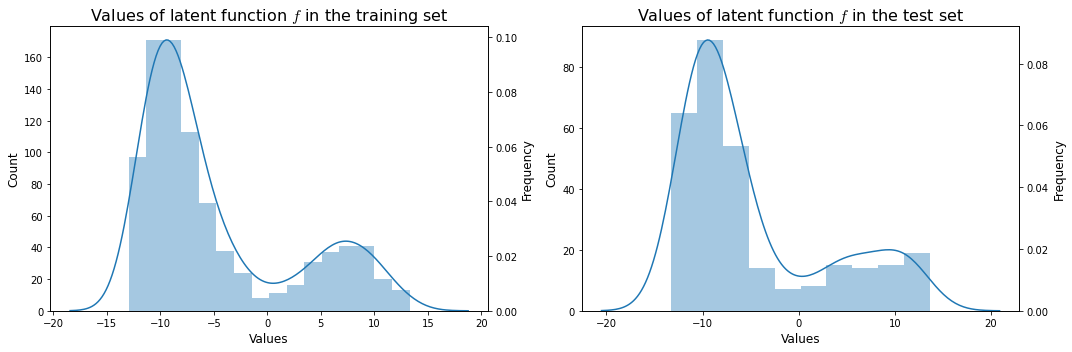

In [175]:
f = pystan_utils.vb_extract_variable(fit_GP, "f", var_type="vector")

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
ax = sns.distplot(f[:900], kde=False)
ax.set_title(r"Values of latent function $f$ in the training set", fontsize = 16)
ax.set_xlabel("Values", fontsize = 12);
ax.set_ylabel("Count", fontsize = 12)
ax2 = plt.twinx()
ax2 = sns.distplot(f[:900], kde=True, hist=False, ax=ax2)
ax2.set_ylabel("Frequency", fontsize = 12)
ax2.set_xlabel("Values", fontsize = 12);

plt.subplot(1, 2, 2)
ax = sns.distplot(f[900:], kde=False)
ax.set_title(r"Values of latent function $f$ in the test set", fontsize = 16)
ax.set_xlabel("Values", fontsize = 12);
ax.set_ylabel("Count", fontsize = 12)
ax2 = plt.twinx()
ax2 = sns.distplot(f[900:], kde=True, hist=False, ax=ax2)
ax2.set_ylabel("Frequency", fontsize = 12)

plt.tight_layout()

# Gaussian processes with Automatic Relevance Determination

Sometimes the goal of a supervised learning is not only to learn the relationships between predictors and target variable but also to **assess their relevance for prediction**. It may be beneficial to deem some of the input variables as irrelevant for the prediction, meaning that they have a very **low predictive power on the target variable** [12].  

In some applications disregarding some of the input features can yield some advantages. Firs of all, the model may become **more interpretable** by being simpler and less complex. Secondly, it can contribute to **reducing the cost** associated with doing the measurements or simply avoid them if they are difficult to obtain, which may be useful in case of wine diagnostics.  

Therefore, the goal of this section is to try to define the relevancy of the features used for wine color prediction using **Automatic Relevance Determination** method and discuss its potential drawbacks.

By employing ARD for Gaussian processes, we slightly modify the squared-exponential (SE) by specifying a **separate length scale for each of the input features**. This is done as follows:  

\begin{align}
cov(f, f_{*}) = k(x, x^{*}) = \alpha^{2}exp(-\frac{1}{2}\sum_{d=1}^D\frac{ (x_{d} - x^{*}_{d})^{2}}{l^{2}_{d}}),
\end{align}

Here each of the $D$ input dimensions is given a seperate length scale parameter $l$ which allow the function to vary at different scales with respect to different inputs [13][14]. The idea behind this is that if $l$ is very large, there will be **no correlation** between the latent function values in that dimension (in that case we calculate the exponent of a very small value, which will be very close to 0). Thus, the **covariance becomes almost independent of that input**, which means it is no longer important for us.

Therefore, length scales can be viewed as a **total effect measure** and used to determine the relevance of a particular input.

## PGM

<center><img src="https://drive.google.com/uc?id=1XC_qE1ukO_zIKca6cD_wPgSmZ1caKpsl"></center>

There is a slight change in the PGM of the previous GP model in the form of the plate over the the length-scale parameter, which is now a vector of length $D$, where each value corresponds to one input dimension $d$.

## Generative process

1. For each input dimension $d$:  
  a) Draw length scale $l_{d} \sim Inv\_Gamma(l_{d}|5, 5)$.  
2. Draw output variance $\alpha \sim N(\alpha|0, 5)$.  
3. Draw $a \sim N(a|0, 1)$.  
4. Draw $\eta \sim N(\eta|0, 1)$.  
5. Calculate $f = Cholesky\_decompose(SE(\textbf{x}, \alpha, \textbf{l})) * \eta$.  
6. For each observation $n$:  
    a) $y_n \sim \mathcal{Bernoulli}(y_n | sigmoid(a + f_n))$.

## STAN model

The implementation of a Gaussian process classification is extended with a function that calculates the covariance matrix using **element-wise division by the length scale parameter** corresponding to each of the input features.

In [176]:
gaussian_processes = """ 
functions {
  matrix L_cov_exp_quad_ARD(vector[] x,
                            real alpha,
                            vector length_scale,
                            real delta) {
    int N = size(x);
    matrix[N, N] K;
    real sq_alpha = square(alpha);
    for (i in 1:(N-1)) {
      K[i, i] = sq_alpha + delta;
      for (j in (i + 1):N) {
        K[i, j] = sq_alpha
                      * exp(-0.5 * dot_self((x[i] - x[j]) ./ length_scale));  // element-wise division (separate length-scale for each input dimension)
        K[j, i] = K[i, j];
      }
    }
    K[N, N] = sq_alpha + delta;             // adding positive noise to the diagonal
    return cholesky_decompose(K);
  }
}
data {
    int<lower=1> D;

    int<lower=1> N_train;
    vector[D] x_train[N_train];
    int<lower=0, upper=1> y_train[N_train];

    int<lower=1> N_test;
    vector[D] x_test[N_test];              // array of vectors
}
transformed data {
    real delta = 1e-9;                     // small positive term that needs to be added to the diagonal of 
                                           // covariance matrix to ensure that it is positive
    int<lower=1> N = N_train + N_test;
    vector[D] x[N];
    for (n in 1:N_train) x[n] = x_train[n];
    for (n in 1:N_test) x[N_train + n] = x_test[n];
}
parameters {
    vector<lower=0>[D] length_scale;       // VECTOR of scales at which distances are measured among inputs
    real<lower=0> alpha;                   // scale of the output values, half-normal
    real a;                                // bias term
    vector[N] eta;                         // vector of univariate normals
}
transformed parameters {
    vector[N] f;
    {
        matrix[N, N] L_K = L_cov_exp_quad_ARD(x, alpha, length_scale, delta);
        f = L_K * eta;
    }
} 
model {
    length_scale ~ inv_gamma(5, 5);
    alpha ~ normal(0, 5);
    a ~ std_normal();
    eta ~ std_normal();

    y_train ~ bernoulli_logit(a + f[1:N_train]);
}
generated quantities {
    int<lower=0, upper=1> y_pred[N_test];
    real<lower=0, upper=1> prob[N_test];
    for (n in 1:N_test) {
        prob[n] = inv_logit(a + f[N_train + n]);
        y_pred[n] = bernoulli_logit_rng(a + f[N_train + n]);
    }
}
"""

# Compile Stan model
sm = pystan.StanModel(model_code = gaussian_processes)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4a290470c868bdce0b04009d19f8646f NOW.


Now we will use **all of the available features** as our predictors in order to see which one of them will be deemed irrelevant according to the length scale parameter of the covariance function.

In [201]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
data = data[data['residual sugar'] < 63].copy() # Remove outlier
data_sampled = data.sample(1200, random_state=42)
X = data_sampled[features]
y = data_sampled['color']
y = (y == 'red').astype(int) # 1 if color is red

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle = True, stratify = y)

X_train = (X_train - np.mean(X_train))/np.std(X_train)
X_test = (X_test - np.mean(X_test))/np.std(X_test)

In [184]:
# Data preparation
N_train, D = X_train.shape
N_test = X_test.shape[0]
print("N_train = %d, N_test = %d, D = %d" % (N_train, N_test, D))
d = {'N_train': N_train, 'N_test': N_test, 'D': D, 'x_train': X_train, 'x_test': X_test, 'y_train': y_train}

N_train = 900, N_test = 300, D = 11


In [185]:
%%time
fit_GP_ARD = sm.vb(data = d, iter = 1000, algorithm = "meanfield", seed = 42, verbose=True, output_samples = 300) 

CPU times: user 23min 10s, sys: 9.75 s, total: 23min 20s
Wall time: 23min 13s


In [186]:
y_pred = pystan_utils.vb_extract_variable(fit_GP_ARD, "y_pred", var_type="vector")
print("Accuracy:", np.sum(y_pred == y_test)/len(y_test))

Accuracy: 0.9966666666666667


In this case the accuracy is even higher than for the basic Gaussian processes model, however, it must be taken into account that here we used all 11 features.

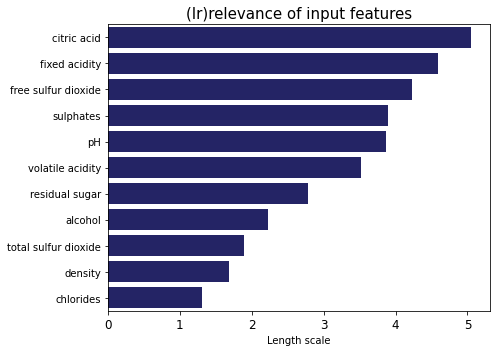

In [200]:
length_scales = pystan_utils.vb_extract_variable(fit_GP_ARD, "length", var_type="vector")
summary = pd.DataFrame(data = [X_train.columns, length_scales]).T
summary.columns = ['Feature', 'Length scale']
summary = summary.set_index('Feature')
summary = summary.sort_values(ascending = False, by = 'Length scale')

plt.figure(figsize = (7, 5))
sns.barplot(y = summary.index, x = summary['Length scale'], color = 'midnightblue')
plt.title("(Ir)relevance of input features", fontsize = 15)
plt.ylabel("Length scale", fontsize = 14); plt.ylabel("");
plt.xticks(fontsize = 12);
plt.tight_layout()
plt.savefig("GP_ARD.png")

The above plot presents the estimated value of length scale parameter for each of the input dimensions. The higher the value, the less relevant the feature is for the prediction. It looks like `citric acid`, `free sulfur dioxide` and `fixed acidity` are the the free variables with the **lowest prediction power**. On the other hand, **`total sulfur dioxide`**, **`chlorides`**, **`density`** and **`residual sugar`** can help us most in determining the color of wine.

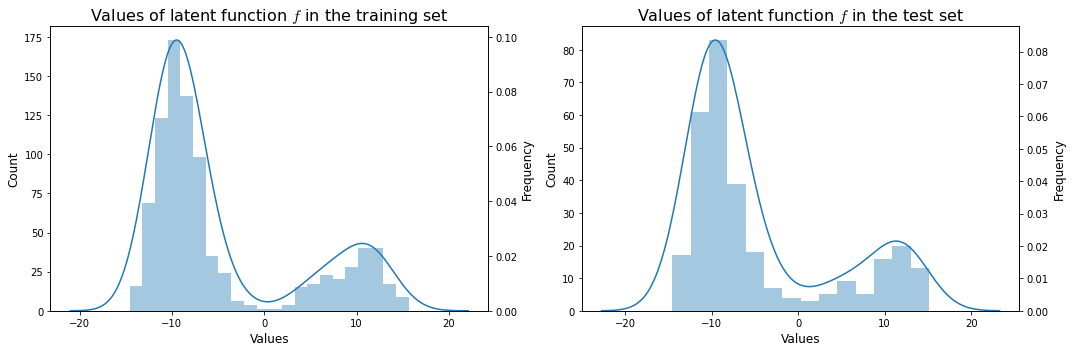

In [188]:
f = pystan_utils.vb_extract_variable(fit_GP_ARD, "f", var_type="vector")

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
ax = sns.distplot(f[:900], kde=False)
ax.set_title(r"Values of latent function $f$ in the training set", fontsize = 16)
ax.set_xlabel("Values", fontsize = 12);
ax.set_ylabel("Count", fontsize = 12)
ax2 = plt.twinx()
ax2 = sns.distplot(f[:900], kde=True, hist=False, ax=ax2)
ax2.set_ylabel("Frequency", fontsize = 12)
ax2.set_xlabel("Values", fontsize = 12);

plt.subplot(1, 2, 2)
ax = sns.distplot(f[900:], kde=False)
ax.set_title(r"Values of latent function $f$ in the test set", fontsize = 16)
ax.set_xlabel("Values", fontsize = 12);
ax.set_ylabel("Count", fontsize = 12)
ax2 = plt.twinx()
ax2 = sns.distplot(f[900:], kde=True, hist=False, ax=ax2)
ax2.set_ylabel("Frequency", fontsize = 12)

plt.tight_layout()

The two histograms present values of the latent functions separately for training and test cases. It can be observed that for the training set the values are **completely separated** which could indicate 100% performance on the training set. However, this may again vary depending on how hard to classify the observations we sampled are.  
Naturally, the separation is not so obvious for the test set although the two classes can still be clearly distinguished.  
Looking at this plot we can also observe how the classes are **imbalanced**.

## Discussion

Some of the sources [11][13][14] argue that interpreting the value of length-scale parameter $l$ as a measure of relevancy can be misleading. It is true that infinite values of $l$ imply that the covariance function will be constant (flat) along this particular input. However, we will not get infinite values in practice and claiming the same for large but finite values can be problematic. The reason is that ARD overestimates the predictive relevance of **nonlinear variables relative to linear variables of EQUAL relevance**. Thus, the length-scale may happen to be an unreliable indicator of predictive relevance due to its tendency of **favoring nonlinear input**. Alternative approaches to feature selection problems were presented in [13] and [14].

Nevertheless, in our example, allowing for individual lengths scales **increased the flexibility of the model** and improved the fit compared to using the same length scale for all the input, which is reflected in the **highest accuracy score among all of the tested models** and outperforming the sklearn baseline.

# References

[1] https://www.aromadictionary.com/articles/sulfurdioxide_article.html. Accessed: 06.04.2021.  
[2] https://www.piwine.com/use-and-measurement-of-sulfur-dioxide-in-wine.html. Accessed: 06.04.2021.  
[3] https://cran.r-project.org/web/packages/rstanarm/vignettes/rstanarm.html. Accessed: 07.04.2021.  
[4] https://mc-stan.org/docs/2_18/reference-manual/effective-sample-size-section.html. Accessed: 07.04.2021.  
[5] N. Choudhuria, S. Ghosalb, A. Royc. (2006). *Nonparametric binary regression using a Gaussian process prior*. https://www4.stat.ncsu.edu/~sghosal/papers/binary_method.pdf.<br>
[6] http://katbailey.github.io/post/gaussian-processes-for-dummies/. Accessed: 20.05.2021.<br>
[7] O. Obrezanova, M. D. Segall. *Gaussian Processes for Classification:
Modeling of Blood-Brain Barrier Penetration
and hERG Inhibition*. https://www.optibrium.com/downloads/Gaussian%20Processes%20Category%20Models%20White%20Paper.pdf.<br>
[8] C. E. Rasmussen, C. K. I. Williams. *Gaussian Processes for Machine Learning*. MIT Press. (2006). www.GaussianProcess.org/gpml.<br>
[9] Rob Trangucci. (2017). *Hierarchical Gaussian Processes in Stan*. https://mc-stan.org/events/stancon2017-notebooks/stancon2017-trangucci-hierarchical-gps.pdf.<br>
[10] F. Rodrigues, F. Pereira. (2021). Lecture 12 on Gaussian Processes. Model-based Machine Learning course (42186).  
[11] *10.3 Fitting a Gaussian Process*. Stan User's Guide. https://mc-stan.org/docs/2_18/stan-users-guide/fit-gp-section.html. Accessed: 21.05.2021.  
[12] A. Vehtari, J. Ojanen, et al. (2012). *A survey of
Bayesian predictive methods for model assessment, selection and comparison.* https://findit.dtu.dk/en/catalog/2531962656.<br>
[13] J. Piironen and A. Vehtari. (2016). *Projection predictive model selection for Gaussian processes*. https://findit.dtu.dk/en/catalog/2670169885.<br>
[14] T. Paananen, J. Piironen., et al. (2017). *Variable selection for Gaussian processes via sensitivity analysis of the posterior predictive distribution*. https://findit.dtu.dk/en/catalog/2605127536.